# 1. Vertex AI: AutoML

En esta notebook se mostrará cómo crear trabajos de entrenamiento usando AutoML y cómo crear componentes custom de Kubeflow (KFP) en Vertex. 

- El pipeline empieza con la ingesta de la data desde BigQuery.
- Luego entrena un modelo de AutoML usando servicios gestionados de Vertex (Models, Datasets).
- En función de la performance de ese modelo según su AUC, se toma una decisión: deployar o no.
- En caso de que se decida deployar, se crea un endpoint que queda prendido para ser utilizado de forma general.

La celda de abajo importa librerías y crea algunas variables:

In [1]:
# Librerias generales
import os
from datetime import datetime
from typing import NamedTuple

# Librerias propias del uso de GCP
import google.cloud.aiplatform as aip
from google_cloud_pipeline_components import aiplatform as gcc_aip

# Librerias de Kubeflow Pipelines
import kfp
from kfp.v2 import dsl
from kfp.v2.dsl import (Artifact, ClassificationMetrics, Input, Metrics,
                        Output, component)
from kfp.v2 import compiler

# Variables de entorno
PATH=%env PATH
%env PATH={PATH}:/home/jupyter/.local/bin

PROJECT_ID = ""
if not os.getenv("IS_TESTING"):
    shell_output=!gcloud config list --format 'value(core.project)' 2>/dev/null
    PROJECT_ID = shell_output[0]

TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")
REGION="us-central1"
BQ_ORIGINAL_SOURCE = "bq://aju-dev-demos.beans.beans1"
BUCKET_NAME = f'{PROJECT_ID}-vertex-01-automl'
PIPELINE_ROOT = f"gs://{BUCKET_NAME}/pipeline_root/"
API_ENDPOINT = "{}-aiplatform.googleapis.com".format(REGION)
API_ENDPOINT_NAME = 'workshop-vertex-automl-endpoint'
PIPELINE_NAME = "workshop-vertex-automl"
PACKAGE_PATH = f"workshop-vertex-automl-{TIMESTAMP}.json"
DISPLAY_RUN_NAME = f'{PIPELINE_NAME}-{TIMESTAMP}'
MACHINE_TYPE = "n1-standard-4"
CACHE_SPEC = True

print("")

print("Algunas variables que necesitamos:")
print("Timestamp: ", TIMESTAMP)
print("Nuestro Project ID es: ", PROJECT_ID)
print("Nuestra región de GCP es: ", REGION)
print("Fuente original en BigQuery: ", BQ_ORIGINAL_SOURCE)
print("El bucket que usamos es: ", BUCKET_NAME)
print('Nombre del pipeline: ', PIPELINE_NAME)
print('JSON de config del pipeline: ', PACKAGE_PATH)
print("La carpeta root del pipeline es: ", PIPELINE_ROOT)
print('Nombre de esta ejecución: ', DISPLAY_RUN_NAME)
print('Tipo de máquina del entrenamiento: ', MACHINE_TYPE)
print("El endpoint va a estar alojado en: ", API_ENDPOINT)
print("El nombre del endpoint va a ser: ", API_ENDPOINT_NAME)
print("Habilitar cache: ", CACHE_SPEC)



env: PATH=/usr/local/cuda/bin:/opt/conda/bin:/opt/conda/condabin:/usr/local/bin:/usr/bin:/bin:/usr/local/games:/usr/games:/home/jupyter/.local/bin

Algunas variables que necesitamos:
Timestamp:  20220614180933
Nuestro Project ID es:  vertex-playground-352219
Nuestra región de GCP es:  us-central1
Fuente original en BigQuery:  bq://aju-dev-demos.beans.beans1
El bucket que usamos es:  vertex-playground-352219-vertex-01-automl
Nombre del pipeline:  workshop-vertex-automl
JSON de config del pipeline:  workshop-vertex-automl-20220614180933.json
La carpeta root del pipeline es:  gs://vertex-playground-352219-vertex-01-automl/pipeline_root/
Nombre de esta ejecución:  workshop-vertex-automl-20220614180933
Tipo de máquina del entrenamiento:  n1-standard-4
El endpoint va a estar alojado en:  us-central1-aiplatform.googleapis.com
El nombre del endpoint va a ser:  workshop-vertex-automl-endpoint
Habilitar cache:  True


- **Timestamp**: Suele ser necesario para hacer un identificador único de algunos elementos y artefactos clave: el run del pipeline, generaciones de logs, etc. Va a aparecer varias veces en el código.
- **Project ID**: Argumento muy utilizado en la ejecución de comandos usando las APIs/SDK. ¿Cómo saben a quién cobrarle sino? :P
- **Región**: Ídem arriba. Es importante tratar de mantener una homogeneidad en las regiones para evitar latencia y conflictos de permisos, microservicios que no se ven (o directamente no están disponibles), etc.
- **Fuente original de GCP**: Eso mismo: la base original con el dataset de los porotos.
- **Bucket**: El bucket raíz donde van a alojarse todos los artefactos.
- **Nombre del pipeline**: La idea es agrupar distintas temáticas de forma clara para saber de un vistazo que estás haciendo.
- **JSON de config del pipeline**: Vamos a ver más adelante que estos pipelines generan un JSON con la definición total del pipeline. Ese JSON lo va a usar el compilador del pipeline, y es reutilizable.
- **Pipeline root**: Cementerio de artefactos.
- **Nombre de la ejecución**: La idea sería agregar algunos detalles específicos de lo que se hizo, para poder verlo de un vistazo.
- **Tipo de máquina del entrenamiento**: Uno de los múltiples puntos posibles de definición de infraestructura: ¿con qué queremos ejecutar esa parte?
- **Endpoint**: Están alojados en distintas regiones (¿vieron que era importante?), entonces tenemos que indicarle cuál es la URL de la región en la que estamos trabajando.
- **Nombre del endpoint**: Identificador del endpoint.
- **Habilitar caché**: Exprimir cada centavo.

Pero antes...

### 1.1. Pequeñísima intro a Kubeflow Pipelines (KFP)

Veamos primero las nociones elementales de KFP. Un componente sencillo podría tener esta forma:

In [2]:
@component(base_image="python:3.9", 
           output_component_file="01_soy_un_componente.yaml", 
           packages_to_install=["pandas"])
def product_name(text: str) -> NamedTuple(
    "Outputs",
    [
        ("name", str),  # Return parameters
        ("greeting", str),
    ],
):
    name = text
    greeting = 'hola ' + text
    return (name, greeting)

- Con el decorador @component se indica que estamos armando un componente de KFP, que después se compilará en el armado del pipeline.
- Hay una imagen de base a partir de la cual se construye el componente.
- La flecha -> indica el tipo del output. Como veremos más adelante, se pueden hacer distintos tipos de outputs, por ejemplo, una NamedTuple. Siendo que estas tuplas tienen keys podés llamarlas y que te devuelvan el valor (eso se va a usar más adelante).
- packages_to_install es un argumento opcional, que indica librerías y módulos a ser instalados en la compilación.
- output_component_file es un argumento opcional, que construye un yaml con el componente escrito. Si después se quiere trabajar con ese yaml, se hace de la siguiente manera:

In [14]:
componente_custom_yaml = kfp.components.load_component_from_file('01_soy_un_componente.yaml')

Estos componentes se ordenan en una función de pipeline que ordena los pasos de manera secuencial y cómo se encadenan cada uno de ellos.

### 1.2. Componente custom: evaluación del modelo

Primero se creará un componente custom que ilustra una ventaja de los modelos de AutoML: la cantidad de metadatos almacenados dentro de la misma suite de Vertex.

In [3]:
@component(
    base_image="gcr.io/deeplearning-platform-release/tf2-cpu.2-6:latest",
    output_component_file="tabular_eval_component.yaml",
    packages_to_install=["google-cloud-aiplatform"],
)
def classification_model_eval_metrics(
    project: str,
    location: str,  # "us-central1",
    api_endpoint: str,  # "us-central1-aiplatform.googleapis.com",
    thresholds_dict_str: str,
    model: Input[Artifact],
    metrics: Output[Metrics],
    metricsc: Output[ClassificationMetrics],
) -> NamedTuple("Outputs", [("dep_decision", str)]):  # Return parameter.

    import json
    import logging

    from google.cloud import aiplatform as aip

    # Fetch model eval info
    def get_eval_info(client, model_name):
        from google.protobuf.json_format import MessageToDict

        response = client.list_model_evaluations(parent=model_name)
        metrics_list = []
        metrics_string_list = []
        for evaluation in response:
            print("model_evaluation")
            print(" name:", evaluation.name)
            print(" metrics_schema_uri:", evaluation.metrics_schema_uri)
            metrics = MessageToDict(evaluation._pb.metrics)
            for metric in metrics.keys():
                logging.info("metric: %s, value: %s", metric, metrics[metric])
            metrics_str = json.dumps(metrics)
            metrics_list.append(metrics)
            metrics_string_list.append(metrics_str)

        return (
            evaluation.name,
            metrics_list,
            metrics_string_list,
        )

    # Use the given metrics threshold(s) to determine whether the model is
    # accurate enough to deploy.
    def classification_thresholds_check(metrics_dict, thresholds_dict):
        for k, v in thresholds_dict.items():
            logging.info("k {}, v {}".format(k, v))
            if k in ["auRoc", "auPrc"]:  # higher is better
                if metrics_dict[k] < v:  # if under threshold, don't deploy
                    logging.info("{} < {}; returning False".format(metrics_dict[k], v))
                    return False
        logging.info("threshold checks passed.")
        return True

    def log_metrics(metrics_list, metricsc):
        test_confusion_matrix = metrics_list[0]["confusionMatrix"]
        logging.info("rows: %s", test_confusion_matrix["rows"])

        # log the ROC curve
        fpr = []
        tpr = []
        thresholds = []
        for item in metrics_list[0]["confidenceMetrics"]:
            fpr.append(item.get("falsePositiveRate", 0.0))
            tpr.append(item.get("recall", 0.0))
            thresholds.append(item.get("confidenceThreshold", 0.0))
        print(f"fpr: {fpr}")
        print(f"tpr: {tpr}")
        print(f"thresholds: {thresholds}")
        metricsc.log_roc_curve(fpr, tpr, thresholds)

        # log the confusion matrix
        annotations = []
        for item in test_confusion_matrix["annotationSpecs"]:
            annotations.append(item["displayName"])
        logging.info("confusion matrix annotations: %s", annotations)
        metricsc.log_confusion_matrix(
            annotations,
            test_confusion_matrix["rows"],
        )

        # log textual metrics info as well
        for metric in metrics_list[0].keys():
            if metric != "confidenceMetrics":
                val_string = json.dumps(metrics_list[0][metric])
                metrics.log_metric(metric, val_string)
        # metrics.metadata["model_type"] = "AutoML Tabular classification"

    logging.getLogger().setLevel(logging.INFO)
    aip.init(project=project)
    # extract the model resource name from the input Model Artifact
    model_resource_path = model.metadata["resourceName"]
    logging.info("model path: %s", model_resource_path)

    client_options = {"api_endpoint": api_endpoint}
    # Initialize client that will be used to create and send requests.
    client = aip.gapic.ModelServiceClient(client_options=client_options)
    eval_name, metrics_list, metrics_str_list = get_eval_info(
        client, model_resource_path
    )
    logging.info("got evaluation name: %s", eval_name)
    logging.info("got metrics list: %s", metrics_list)
    log_metrics(metrics_list, metricsc)

    thresholds_dict = json.loads(thresholds_dict_str)
    deploy = classification_thresholds_check(metrics_list[0], thresholds_dict)
    if deploy:
        dep_decision = "true"
    else:
        dep_decision = "false"
    logging.info("deployment decision is %s", dep_decision)

    return (dep_decision,)

Veamos un poco algunos detalles:

- El input es metadata a nivel proyecto, un modelo entrenado y un cierto umbral (threshold), definido en la ejecución del pipeline, que define si el modelo se deploya o no.
- Es interesante que si bien el modelo deja loggeados ciertos artefactos (en este caso, métricas del modelo), el output es básicamente una tupla con un string true/false en función de cómo le fue al modelo.
- Este código hace gala de una de las ventajas de AutoML: la sencillez con la que se puede obtener metadata. En los modelos de AutoML, la suite provee una gama de herramientas de evaluación desde la interfaz gráfica, cuya información es la que se accede desde el código de este componente:

### 1.3. Definición del pipeline

Una función de pipeline requiere obligatoriamente el root path donde almacenará los distintos artefactos que se generan en el proceso. En esta clase de procesos, los distintos microservicios van dejando pequeños rastros de lo que hacen o lo que pasó. 

Estos artefactos (registros, logs, porciones de datasets, pickles, etc.) son importantísimos no sólo para tener trazabilidad y control de lo que está sucediendo en nuestra arquitectura, sino también para usarlo como herramienta para que el sistema tome ciertas decisiones de manera automatizada (reentrenar, pasar a prod, cambiar el dataset, etc.).  

In [4]:
@kfp.dsl.pipeline(name=PIPELINE_NAME,
                  pipeline_root=PIPELINE_ROOT # por alguna razón necesita sí o sí el path con gs://
                 )
def pipeline(
    # 
    # los argumentos de la mano izquierda (bq_source) se pasan en el contexto de esta funcion.
    # ejemplo: ver dataset_create_op
    
    # los argumentos de la mano derecha (BQ_ORIGINAL_SOURCE) son definidos previamente por nosotrxs
    # ejemplos: son todas las variables que estan al inicio de la notebook
    bq_source: str = BQ_ORIGINAL_SOURCE,
    display_name: str = DISPLAY_RUN_NAME,
    project: str = PROJECT_ID,
    gcp_region: str = REGION,
    api_endpoint: str = API_ENDPOINT,
    thresholds_dict_str: str = '{"auRoc": 0.90}',
):
    # paso 1: crea un dataset. El resultado de esa operacion se almacena en un objeto llamado dataset_create_op
    # clave: esos objetos tienen inputs y outputs
    dataset_create_op = gcc_aip.TabularDatasetCreateOp(
        # ejemplo: bq_source es definido como argumento en el contexto de la ejecucion de esta funcion
        project=project, display_name=display_name, bq_source=bq_source
    )

    # paso 2: definicion del training job
    training_op = gcc_aip.AutoMLTabularTrainingJobRunOp(
        project=project,
        display_name=display_name,
        optimization_prediction_type="classification",
        optimization_objective="minimize-log-loss",
        budget_milli_node_hours=1000,
        column_specs={
            "Area": "numeric",
            "Perimeter": "numeric",
            "MajorAxisLength": "numeric",
            "MinorAxisLength": "numeric",
            "AspectRation": "numeric",
            "Eccentricity": "numeric",
            "ConvexArea": "numeric",
            "EquivDiameter": "numeric",
            "Extent": "numeric",
            "Solidity": "numeric",
            "roundness": "numeric",
            "Compactness": "numeric",
            "ShapeFactor1": "numeric",
            "ShapeFactor2": "numeric",
            "ShapeFactor3": "numeric",
            "ShapeFactor4": "numeric",
            "Class": "categorical",
        },
        # vamos a tomar el dataset que sale como output del paso anterior
        # clave: pensar en paths
        dataset=dataset_create_op.outputs["dataset"],
        target_column="Class",
    )
                  
    # paso 3: evaluacion del modelo
    # es un componente custom que toma un determinado modelo
    # lo evalua y en funcion de eso devuelve true o false segun el threshold definido
    model_eval_task = classification_model_eval_metrics(
        project,
        gcp_region,
        api_endpoint,
        thresholds_dict_str,
        
        # el modelo que tiene que evaluar va a venir del paso anterior
        # puede no existir, pensar en paths
        training_op.outputs["model"],
    )

    # objeto Condition del sdk de KFP
    with dsl.Condition(
        # condicion de la ejecucion: que el paso anterior devuelva true
        model_eval_task.outputs["dep_decision"] == "true",
        name="deploy_decision",
    ):

        # de acá en adelante se ejecuta sólo si ocurre la condición
        # primero crea un endpoint
        endpoint_op = gcc_aip.EndpointCreateOp(
            project=project,
            location=gcp_region,
            display_name=API_ENDPOINT_NAME,
        )

        # y luego deploya el modelo recién salido del horno en el endpoint previamente creado
        gcc_aip.ModelDeployOp(
            model=training_op.outputs["model"],
            endpoint=endpoint_op.outputs["endpoint"],
            dedicated_resources_min_replica_count=1,
            dedicated_resources_max_replica_count=1,
            # en este caso toma el mismo tipo de máquina con el que se entrenó
            # pero es muy fácil ir eligiendo distintas arquitecturas en cada paso
            dedicated_resources_machine_type=MACHINE_TYPE,
        )


Repaso:

- Vemos que en la definición del pipeline le decimos que queremos un auRoc de al menos 0.90 para que sea deployable.
- Es muy fácil entrenar un modelo de AutoML e inclusive hacer transformaciones de columnas in situ. Se le indica cuál es el objetivo, cuál es la columna de target (en este caso Class) y con qué dataset tiene que entrenar (que es el resultado del componente anterior!).
- A continuación está el elemento custom del pipeline: la clasificación. Como vimos, toma elementos del modelo entrenado previamente y decide qué es lo que hará.
- Uno de los aspectos interesantes de KFP es la decisión condicional, que es la clase Condition que viene con el SDK de KFP. En caso de que la condición se cumpla el pipeline continuará, de lo contrario, se detendrá. En este caso vemos que si el output del componente de decisión es "true" (o sea, que cumple con el criterio que se definió), se procede a la creación de un endpoint y su correspondiente deploy.
- Tip: Estas librerías cambian **todo el tiempo**, y lo que hoy se llama de una manera, mañana (o ayer) puede llamarse de otra. ¡No perder (demasiado) la paciencia en caso de que algo cambie!

Con el pipeline definido, pasamos a la fase de compilado, que básicamente compone esta función que definimos antes en un paquete en formato JSON.

In [5]:
compiler.Compiler().compile(
    pipeline_func=pipeline,
    package_path=PACKAGE_PATH,
)

/home/jupyter/.local/lib/python3.7/site-packages/kfp/v2/compiler/compiler.py:1266: FutureWarning: APIs imported from the v1 namespace (e.g. kfp.dsl, kfp.components, etc) will not be supported by the v2 compiler since v2.0.0
  category=FutureWarning,


### 1.4. Ejecución del pipeline

Con todo el pipeline compilado, lo utilizamos para preparar un job de entrenamiento, tomando el JSON que generamos y pasándole algunos parámetros adicionales, como el nombre del run en cuestión y si habilitamos el caché.

**Importante**: Este pipeline puede tardar un buen rato, unas dos horas en promedio.

In [6]:
job = aip.PipelineJob(
    display_name=DISPLAY_RUN_NAME,
    template_path=PACKAGE_PATH,
    pipeline_root=PIPELINE_ROOT,
    parameter_values={"project": PROJECT_ID, "display_name": DISPLAY_RUN_NAME},
    enable_caching=CACHE_SPEC,
)
job.submit()

INFO:google.cloud.aiplatform.pipeline_jobs:Creating PipelineJob
INFO:google.cloud.aiplatform.pipeline_jobs:PipelineJob created. Resource name: projects/696333388420/locations/us-central1/pipelineJobs/workshop-vertex-automl-20220614181102
INFO:google.cloud.aiplatform.pipeline_jobs:To use this PipelineJob in another session:
INFO:google.cloud.aiplatform.pipeline_jobs:pipeline_job = aiplatform.PipelineJob.get('projects/696333388420/locations/us-central1/pipelineJobs/workshop-vertex-automl-20220614181102')
INFO:google.cloud.aiplatform.pipeline_jobs:View Pipeline Job:
https://console.cloud.google.com/vertex-ai/locations/us-central1/pipelines/runs/workshop-vertex-automl-20220614181102?project=696333388420


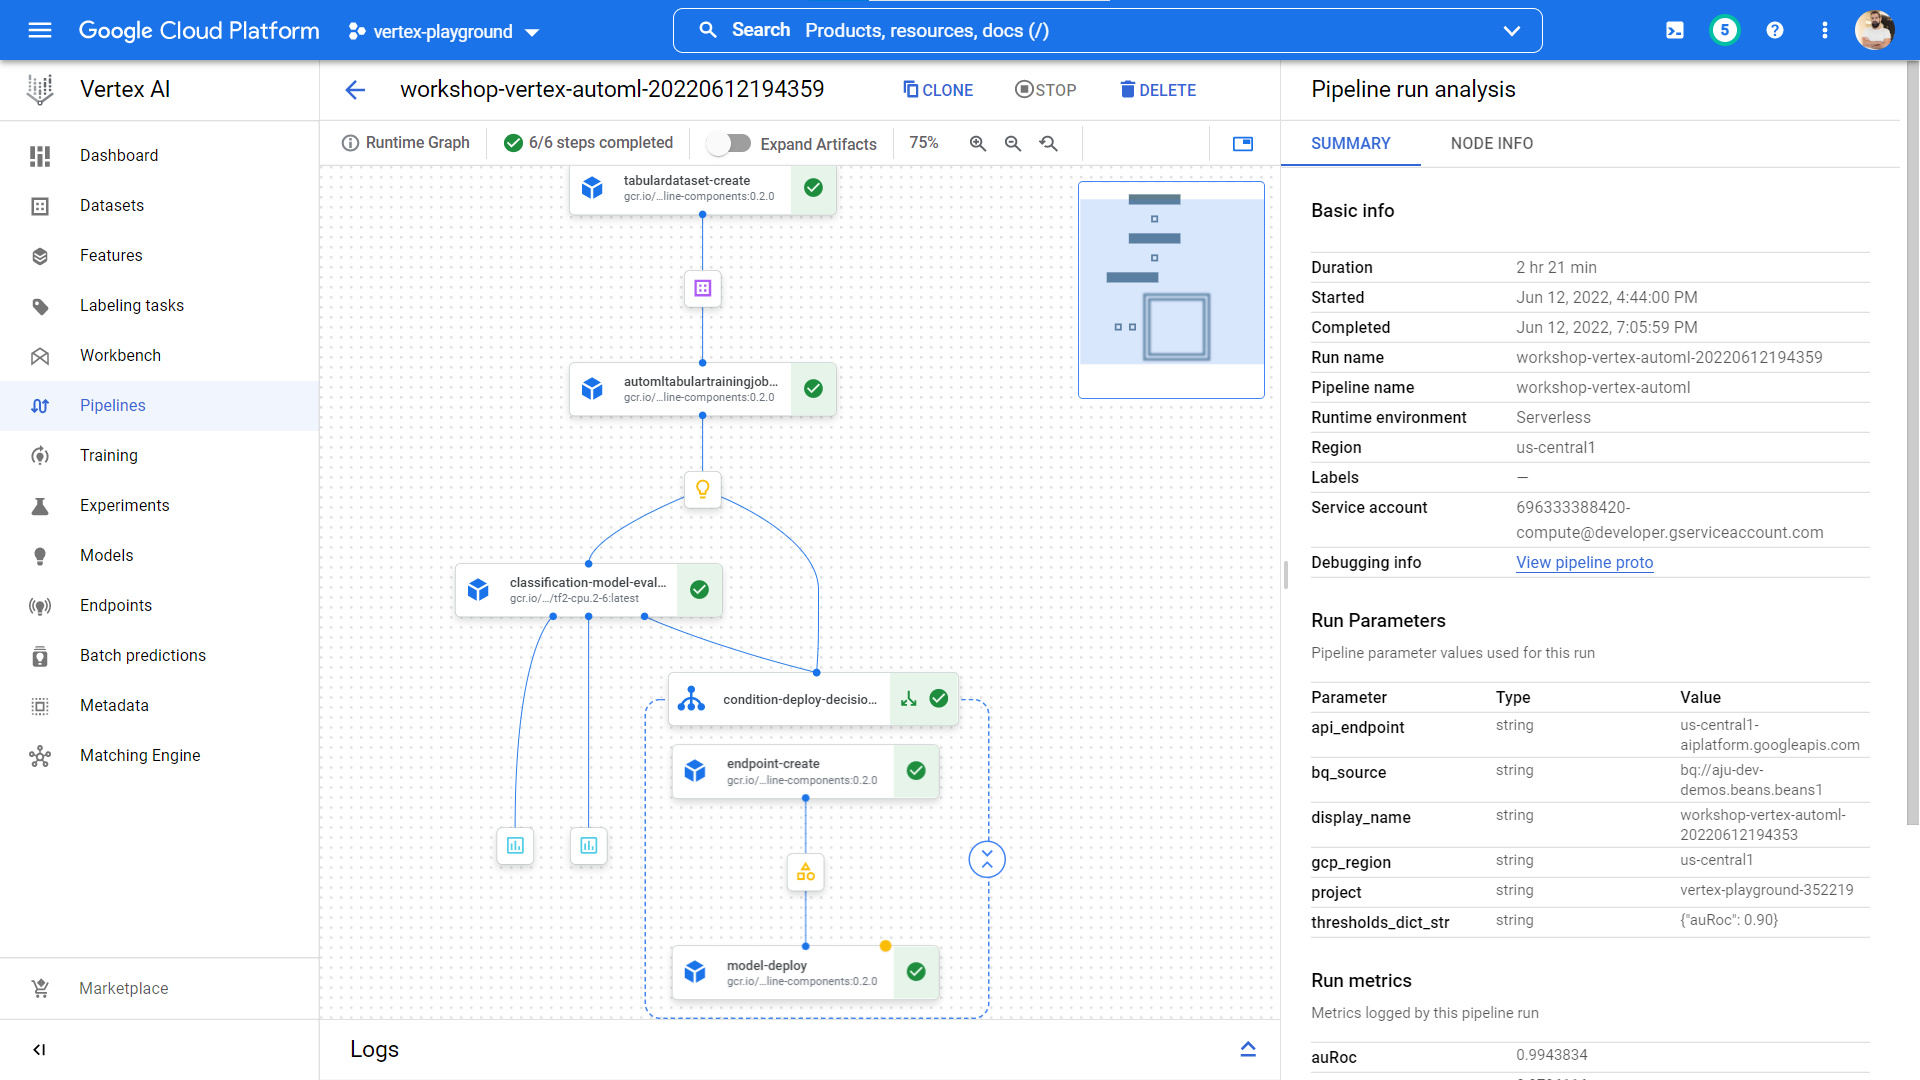

## Limpieza

En la parte de Endpoints, primero hay que undeployar (_des-desplegar_ en castellano, correte Hegel) el modelo y recién ahí podemos borrar el endpoint (que es lo que nos cuesta plata).

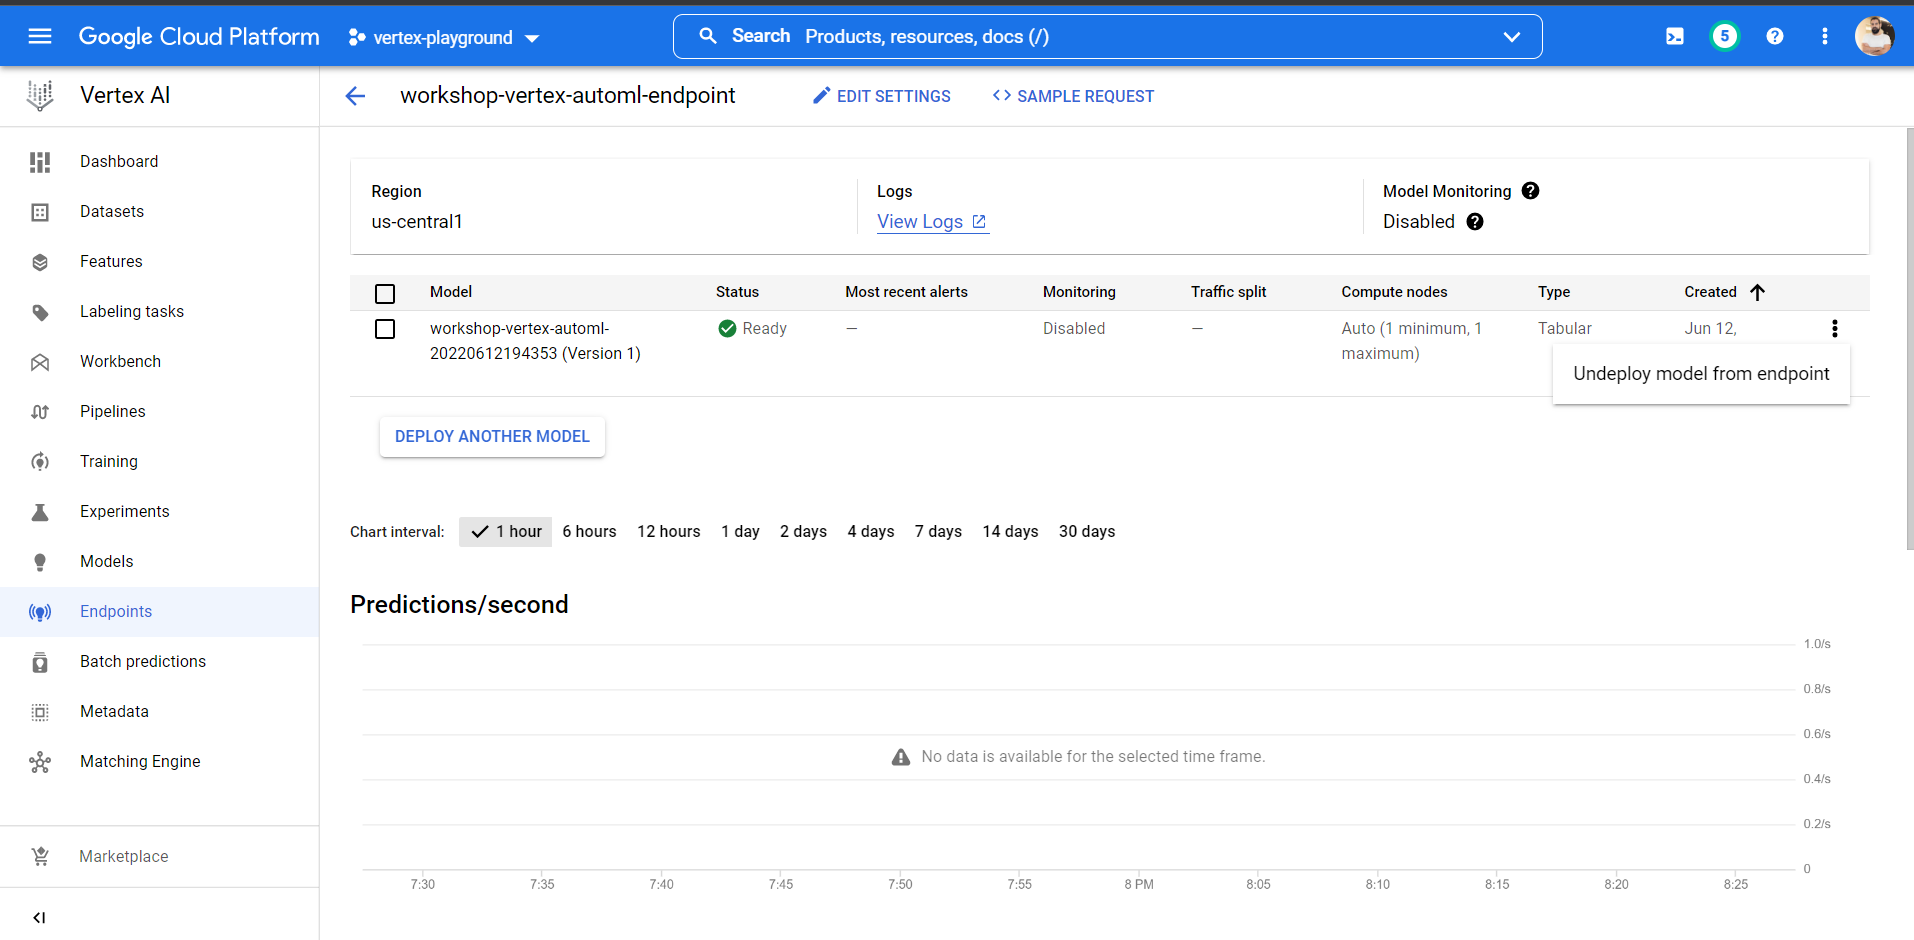

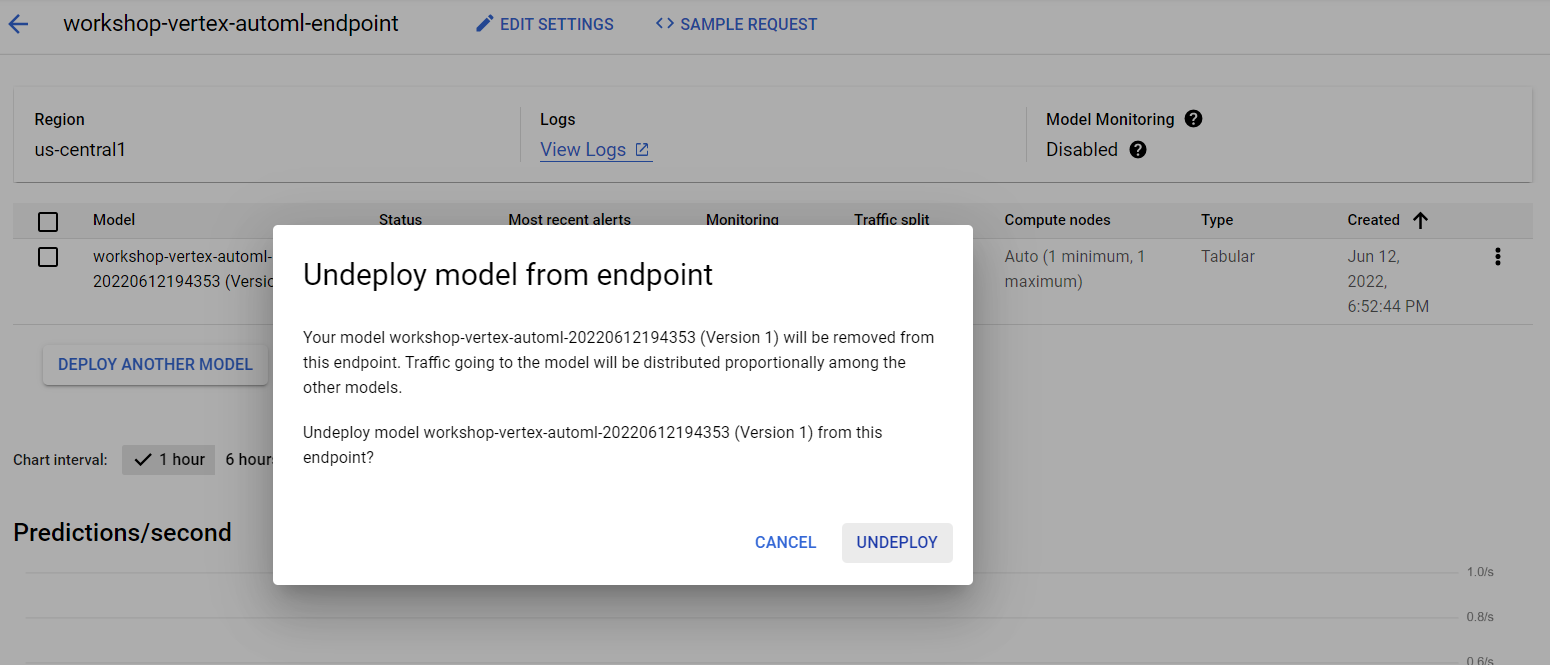

Con el endpoint vacío, lo seleccionamos, clickeamos en los tres puntitos de la derecha y lo removemos.

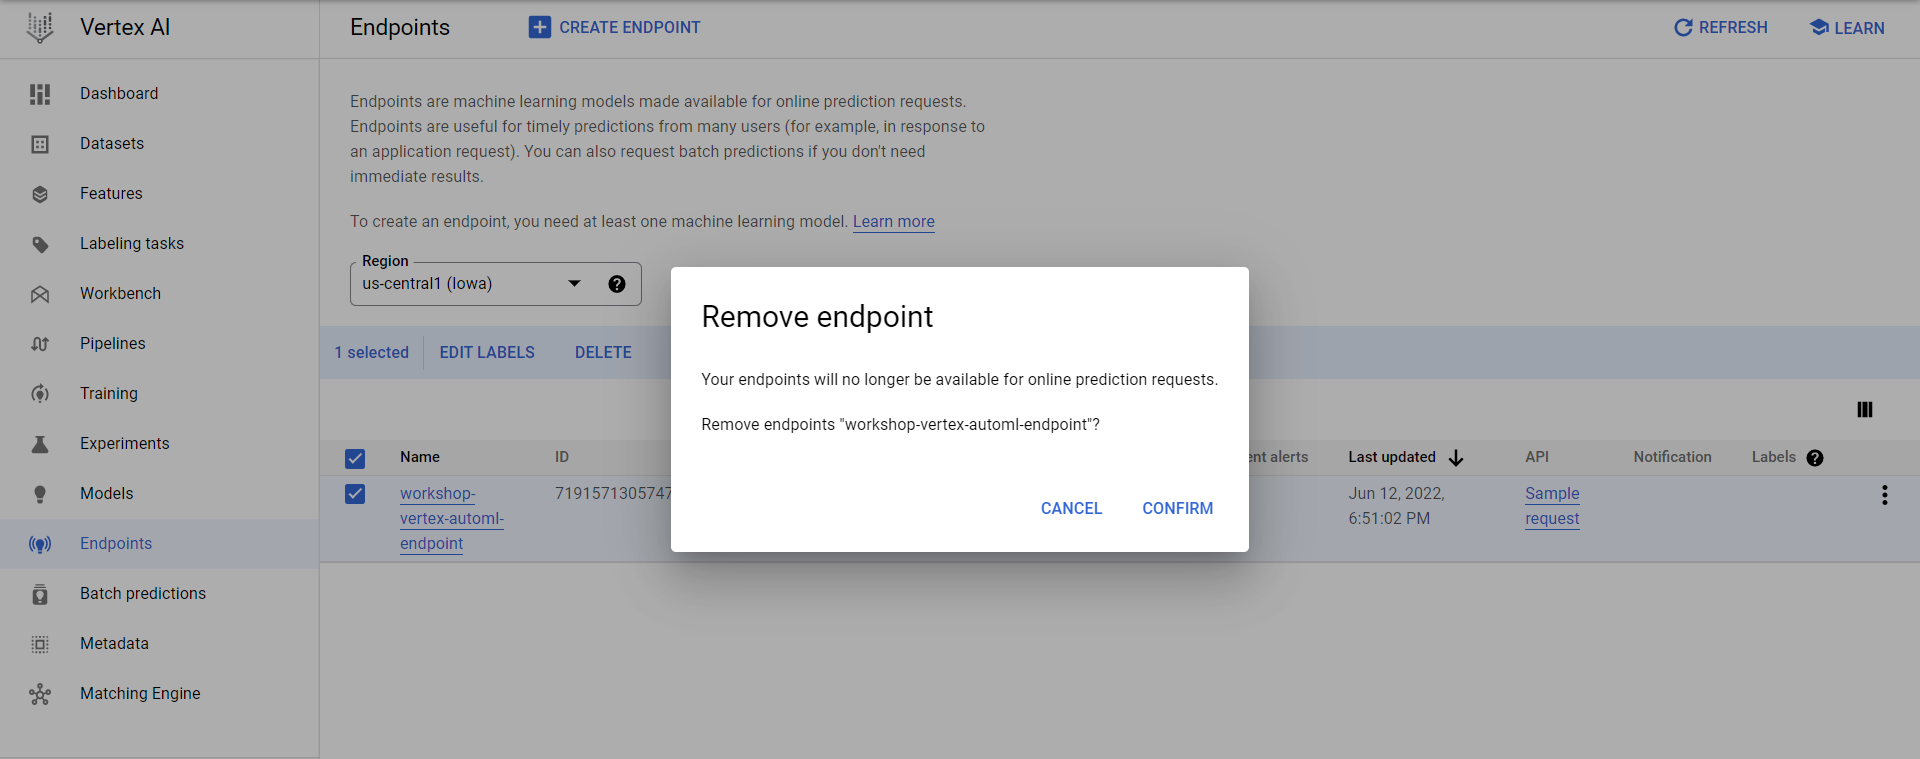